In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Tue Jan 21 14:35:06 PST 2020


# From `lbwsg` categorical risk to a bivariate, continuous risk

In [2]:
import gbd_mapping as gbd

In [3]:
gbd.risk_factors.low_birth_weight_and_short_gestation

RiskFactor(
name='low_birth_weight_and_short_gestation',
kind='risk_factor',
gbd_id=reiid(339),
level=3,
most_detailed=False,
distribution='ordered_polytomous',
population_attributable_fraction_calculation_type='categorical',
restrictions=Restrictions(
male_only=False,
female_only=False,
yll_only=False,
yld_only=False,
yll_age_group_id_start=2,
yll_age_group_id_end=5,
yld_age_group_id_start=2,
yld_age_group_id_end=235,
violated=[exposure_age_restriction_violated, relative_risk_age_restriction_violated, population_attributable_fraction_yll_age_restriction_violated]),
exposure_exists=True,
exposure_year_type='binned',
relative_risk_exists=True,
relative_risk_in_range=True,
population_attributable_fraction_yll_exists=True,
population_attributable_fraction_yll_in_range=True,
population_attributable_fraction_yld_exists=True,
population_attributable_fraction_yld_in_range=True,
affected_causes=[all_causes, communicable_maternal_neonatal_and_nutritional_diseases, diarrheal_diseases, lower_resp

In [4]:
categories = gbd.risk_factors.low_birth_weight_and_short_gestation.categories

In [5]:
# make dataframe that maps from each category to gestatation_age_start,
# gestatation_age_end, birth_weight_start, and birth weight end

s = pd.Series(categories.to_dict())

In [6]:
# set random seed for reproducibility
np.random.seed(12345)

In [7]:
def ga_bw_list(cat):
    numbers_only = cat.replace('Birth prevalence - [', '') \
                    .replace(',', '')\
                    .replace(') wks [', ' ')\
                    .replace(') g', '')
    numbers_only = numbers_only.split()
    numbers_only = [int(numbers_only[i]) for i in range(4)]
    
    return numbers_only


i = np.random.randint(len(s))
s.iloc[i], ga_bw_list(s.iloc[i])

('Birth prevalence - [36, 37) wks, [4000, 4500) g', [36, 37, 4000, 4500])

In [8]:
cat_df = pd.DataFrame(s.map(ga_bw_list).to_dict(), index=['ga_start', 'ga_end', 'bw_start', 'bw_end']).T
cat_df

,ga_start,ga_end,bw_start,bw_end
cat2,0,24,0,500
cat8,0,24,500,1000
cat10,24,26,500,1000
cat11,26,28,500,1000
...,...,...,...,...
cat106,36,37,1000,1500
cat116,38,40,1000,1500
cat117,38,40,1500,2000
cat123,40,42,1500,2000


In [9]:
cat_df['ga_width'] = cat_df['ga_end'] - cat_df['ga_start']
cat_df['bw_width'] = cat_df['bw_end'] - cat_df['bw_start']

In [10]:
def cat_to_ga_bw(cat, p1, p2):
    """Map from category `cat` to bivariate continuous values of birth weight and gestational age
    Parameters
    ----------
    cat : str or list-like of strings, one of the 68 values in index of cat_df
    p1 : float or list-like of floats, propensity between 0 and 1
    p2 : float or list-like of floats, propensity between 0 and 1
    
    Results
    -------
    Returns tuple of (gestational age, birth weight)
    """
    
    ga = cat_df.loc[cat, 'ga_start'] + p1 * cat_df.loc[cat, 'ga_width']
    bw = cat_df.loc[cat, 'bw_start'] + p2 * cat_df.loc[cat, 'bw_width']
    
    return ga, bw

cat = np.random.choice(cat_df.index, size=None)
cat, cat_to_ga_bw(cat, np.random.rand(), np.random.rand())

('cat49', (37.31637555458179, 4091.9594058385474))

In [11]:
def ga_bw_to_cat(ga, bw):
    """Map from (birth weight, gestational age) to category name
    Parameters
    ----------
    ga : float
    bw : float
    
    Results
    -------
    Returns cat for (bw,ga) pair
    """
    
    t = cat_df.query('@bw >= bw_start and @bw < bw_end and @ga >= ga_start and @ga < ga_end')
    assert len(t) >= 1
    return t.index[0]

ga_bw_to_cat(31., 3298.)

'cat89'

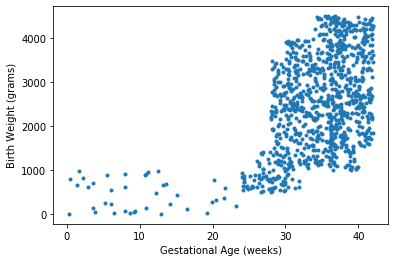

In [12]:
# verification that this works

N = 1_000
cat = np.random.choice(cat_df.index, size=N)
p1 = np.random.rand(N)
p2 = np.random.rand(N)

# from cat to ga and bw
ga, bw = cat_to_ga_bw(cat, p1, p2)
plt.plot(ga, bw, '.')
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('Birth Weight (grams)');

In [13]:
# from ga/bw back to cat
cat2 = list(map(ga_bw_to_cat, ga, bw))

np.mean(cat == cat2)

1.0

In [14]:
# note that there are some categories which overlap
# this is why cat2 is not identical to cat

ga = 5
bw = 666
cat_df.query('@bw >= bw_start and @bw < bw_end and @ga >= ga_start and @ga < ga_end')

,ga_start,ga_end,bw_start,bw_end,ga_width,bw_width
cat8,0,24,500,1000,24,500


In [15]:
# now to fit to appropriate distribution

In [24]:
from db_queries import get_outputs, get_ids, get_covariate_estimates
import pandas as pd
import numpy as np
from gbd_mapping import causes, risk_factors
from vivarium_inputs import get_measure
import gbd_mapping, vivarium_inputs
from get_draws.api import get_draws

In [19]:
locs = get_ids('location_set')
locs[locs['location_set_name'].str.contains('ncome')]

,location_set_id,location_set_name,location_set_description
22,26,World Bank Income Levels,The hierarchy used for the World Bank income l...
62,68,Commonwealth High Income,The set of locations used for the Commonwealth...
63,69,Commonwealth Middle Income,The set of locations used for the Commonwealth...
64,70,Commonwealth Low Income,The set of locations used for the Commonwealth...
69,75,World Bank High Income,The set of locations used for the World Bank H...
70,76,World Bank Low Income,The set of locations used for the World Bank L...
71,77,World Bank Lower Middle Income,The set of locations used for the World Bank L...
72,78,World Bank Upper Middle Income,The set of locations used for the World Bank U...


In [26]:
covars = get_ids('covariate')
covars[covars['covariate_name'].str.contains('ean b')]

,covariate_id,covariate_name,covariate_name_short,covariate_description
391,1136,Mean birth weight,mean_birthweight,Mean birth weight (in grams)
